<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

### Datos
Utilizaremos como dataset los títulos de los artículos de medium.

In [2]:
medium_data = pd.read_csv('./datasets/medium_data.csv')
medium_titles_df = medium_data["title"]

In [3]:
medium_data

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30
...,...,...,...,...,...,...,...,...,...,...
6503,6504,https://medium.com/better-marketing/we-vs-i-ho...,“We” vs “I” — How Should You Talk About Yourse...,Basic copywriting choices with a big…,6504.jpg,661,6,6,Better Marketing,2019-12-05
6504,6505,https://medium.com/better-marketing/how-donald...,How Donald Trump Markets Himself,Lessons from who might be the most popular bra...,6505.jpeg,189,1,5,Better Marketing,2019-12-05
6505,6506,https://medium.com/better-marketing/content-an...,Content and Marketing Beyond Mass Consumption,How to acquire customers without wasting money...,6506.jpg,207,1,8,Better Marketing,2019-12-05
6506,6507,https://medium.com/better-marketing/5-question...,5 Questions All Copywriters Should Ask Clients...,Save time and effort by…,6507.jpg,253,2,5,Better Marketing,2019-12-05


In [4]:
medium_titles_df.head()

0    A Beginner’s Guide to Word Embedding with Gens...
1    Hands-on Graph Neural Networks with PyTorch & ...
2                         How to Use ggplot2 in Python
3    Databricks: How to Save Files in CSV on Your L...
4    A Step-by-Step Implementation of Gradient Desc...
Name: title, dtype: object

In [5]:
print("Cantidad de documentos:", medium_titles_df.shape[0])

Cantidad de documentos: 6508


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [6]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [7]:
# Ejemplo de como transformar una oración a tokens usando keras
text = medium_titles_df.loc[0]
text

'A Beginner’s Guide to Word Embedding with Gensim Word2Vec\xa0Model'

In [8]:
medium_titles_df = medium_titles_df.apply(lambda x: x.replace(u'\xa0',u' '))
medium_titles_df = medium_titles_df.apply(lambda x: x.replace('\u200a',' '))

In [9]:
text = medium_titles_df.loc[0]
text

'A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model'

In [10]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['a',
 'beginner’s',
 'guide',
 'to',
 'word',
 'embedding',
 'with',
 'gensim',
 'word2vec',
 'model']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [11]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in medium_titles_df.items():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [12]:
# Demos un vistazo
sentence_tokens[:2]

[['a'], ['h']]

In [13]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [14]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['a', 'beginner’s', 'guide', 'to'],
 ['beginner’s', 'guide', 'to', 'word'],
 ['guide', 'to', 'word', 'embedding'],
 ['to', 'word', 'embedding', 'with'],
 ['word', 'embedding', 'with', 'gensim'],
 ['embedding', 'with', 'gensim', 'word2vec']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [15]:
tok = Tokenizer() 

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [16]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[8, 6, 4, 1],
 [6, 4, 1, 2],
 [4, 1, 2, 3],
 [1, 2, 3, 5],
 [2, 3, 5, 7],
 [3, 5, 7, 9]]

In [17]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

6


In [18]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

9


In [19]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'to': 1, 'word': 2, 'embedding': 3, 'guide': 4, 'with': 5, 'beginner’s': 6, 'gensim': 7, 'a': 8, 'word2vec': 9}


In [20]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'guide': 3, 'to': 4, 'beginner’s': 2, 'a': 1, 'word': 4, 'embedding': 4, 'with': 3, 'gensim': 2, 'word2vec': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [21]:
# Vistazo a las primeras filas
medium_titles_df.iloc[:15]

0     A Beginner’s Guide to Word Embedding with Gens...
1     Hands-on Graph Neural Networks with PyTorch & ...
2                          How to Use ggplot2 in Python
3     Databricks: How to Save Files in CSV on Your L...
4     A Step-by-Step Implementation of Gradient Desc...
5       An Easy Introduction to SQL for Data Scientists
6                         Hypothesis testing visualized
7     Introduction to Latent Matrix Factorization Re...
8          Which 2020 Candidate is the Best at Twitter?
9             What if AI model understanding were easy?
10    <em class="markup--em markup--h3-em">What I Le...
11                          Making a DotA2 Bot Using ML
12             Building A ‘Serverless’ Chrome Extension
13                                    How to Teach Code
14    Reinventing Personalization For Customer Exper...
Name: title, dtype: object

In [22]:
# Concatenamos todos los rows en un solo valor
corpus = concatenated_value = medium_titles_df.str.cat(sep=' ')
corpus

'A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric How to Use ggplot2 in Python Databricks: How to Save Files in CSV on Your Local Computer A Step-by-Step Implementation of Gradient Descent and Backpropagation An Easy Introduction to SQL for Data Scientists Hypothesis testing visualized Introduction to Latent Matrix Factorization Recommender Systems Which 2020 Candidate is the Best at Twitter? What if AI model understanding were easy? <em class="markup--em markup--h3-em">What I Learned from (Two-time) Kaggle Grandmaster Abhishek Thakur</em> Making a DotA2 Bot Using ML Building A ‘Serverless’ Chrome Extension How to Teach Code Reinventing Personalization For Customer Experience How to Automate Hyperparameter Optimization Ideas: Design Methodologies for Data Sprints RoboSomm Chapter 3: Wine Embeddings and a Wine Recommender Data Science Interview Questions Faster Training for Efficient CNNs Buyers beware, fake 

In [23]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['a',
 'beginner’s',
 'guide',
 'to',
 'word',
 'embedding',
 'with',
 'gensim',
 'word2vec',
 'model',
 'hands',
 'on',
 'graph',
 'neural',
 'networks',
 'with',
 'pytorch',
 'pytorch',
 'geometric',
 'how']

In [24]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 54969


In [25]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [26]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['a', 'beginner’s', 'guide', 'to'],
 ['beginner’s', 'guide', 'to', 'word'],
 ['guide', 'to', 'word', 'embedding'],
 ['to', 'word', 'embedding', 'with'],
 ['word', 'embedding', 'with', 'gensim'],
 ['embedding', 'with', 'gensim', 'word2vec'],
 ['with', 'gensim', 'word2vec', 'model'],
 ['gensim', 'word2vec', 'model', 'hands'],
 ['word2vec', 'model', 'hands', 'on'],
 ['model', 'hands', 'on', 'graph'],
 ['hands', 'on', 'graph', 'neural'],
 ['on', 'graph', 'neural', 'networks'],
 ['graph', 'neural', 'networks', 'with'],
 ['neural', 'networks', 'with', 'pytorch'],
 ['networks', 'with', 'pytorch', 'pytorch'],
 ['with', 'pytorch', 'pytorch', 'geometric'],
 ['pytorch', 'pytorch', 'geometric', 'how'],
 ['pytorch', 'geometric', 'how', 'to'],
 ['geometric', 'how', 'to', 'use'],
 ['how', 'to', 'use', 'ggplot2']]

In [27]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[4, 738, 68, 1],
 [738, 68, 1, 451],
 [68, 1, 451, 1517],
 [1, 451, 1517, 13],
 [451, 1517, 13, 2454],
 [1517, 13, 2454, 3652],
 [13, 2454, 3652, 98],
 [2454, 3652, 98, 1857],
 [3652, 98, 1857, 22],
 [98, 1857, 22, 740],
 [1857, 22, 740, 80],
 [22, 740, 80, 102],
 [740, 80, 102, 13],
 [80, 102, 13, 344],
 [102, 13, 344, 344],
 [13, 344, 344, 1858],
 [344, 344, 1858, 6],
 [344, 1858, 6, 1],
 [1858, 6, 1, 66],
 [6, 1, 66, 3653]]

In [28]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 54965


### 3 - Input y target

In [29]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(54965, 3)
(54965,)


In [30]:
# Palabras del vocabulario
tok.index_word

{1: 'to',
 2: 'the',
 3: 'strong',
 4: 'a',
 5: 'of',
 6: 'how',
 7: 'and',
 8: 'in',
 9: 'your',
 10: 'markup',
 11: 'for',
 12: 'you',
 13: 'with',
 14: 'is',
 15: '—',
 16: 'data',
 17: 'why',
 18: 'class',
 19: 'h3',
 20: 'i',
 21: 'what',
 22: 'on',
 23: 'learning',
 24: 'from',
 25: 'an',
 26: 'be',
 27: 'my',
 28: 'writing',
 29: 'are',
 30: 'it',
 31: 'can',
 32: 'using',
 33: 'design',
 34: 'machine',
 35: 'ux',
 36: 'about',
 37: 'do',
 38: 'not',
 39: 'python',
 40: 'ai',
 41: 'life',
 42: 'that',
 43: 'when',
 44: 'should',
 45: 'we',
 46: '5',
 47: 'science',
 48: 'make',
 49: 'time',
 50: 'need',
 51: 'as',
 52: '3',
 53: 'more',
 54: 'at',
 55: 'business',
 56: 'or',
 57: 'part',
 58: 'have',
 59: 'work',
 60: 'new',
 61: 'don’t',
 62: 'up',
 63: 'by',
 64: 'write',
 65: 'get',
 66: 'use',
 67: 'will',
 68: 'guide',
 69: 'marketing',
 70: '1',
 71: 'ways',
 72: 'deep',
 73: 'best',
 74: 'analysis',
 75: 'first',
 76: '2019',
 77: 'product',
 78: 'better',
 79: 'things',


In [31]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

8236

In [41]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

IndexError: index 8236 is out of bounds for axis 1 with size 8236

In [42]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [43]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(54965, 8236)

### 4 - Entrenar el modelo

In [44]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [45]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

8236

In [38]:

8236 ** (1/4)

9.526405955884277

In [46]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 8236 palabras distintas
# output_dim = 9 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=9, input_length=input_seq_len))
model.add(Bidirectional(LSTM(32)))

#model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
#model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 9)              74133     
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               10752     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 8236)              535340    
                                                                 
Total params: 620,225
Trainable params: 620,225
Non-trainable params: 0
_________________________________________________________________


In [47]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1375/1375 [==============================] - 14s 9ms/step - loss: 7.2609 - accuracy: 0.0451 - val_loss: 7.0877 - val_accuracy: 0.0637
Epoch 2/50
1375/1375 [==============================] - 15s 11ms/step - loss: 6.7412 - accuracy: 0.0734 - val_loss: 7.1199 - val_accuracy: 0.0787
Epoch 3/50
1375/1375 [==============================] - 23s 17ms/step - loss: 6.5643 - accuracy: 0.0845 - val_loss: 7.1068 - val_accuracy: 0.0826
Epoch 4/50
1375/1375 [==============================] - 23s 17ms/step - loss: 6.3928 - accuracy: 0.0932 - val_loss: 7.1141 - val_accuracy: 0.0944
Epoch 5/50
1375/1375 [==============================] - 23s 17ms/step - loss: 6.2120 - accuracy: 0.1099 - val_loss: 7.1665 - val_accuracy: 0.1019
Epoch 6/50
1375/1375 [==============================] - 14s 10ms/step - loss: 6.0192 - accuracy: 0.1224 - val_loss: 7.2206 - val_accuracy: 0.1083
Epoch 7/50
1375/1375 [==============================] - 12s 9ms/step - loss: 5.8274 - accuracy: 0.1324 - val_loss: 7.3205 - v

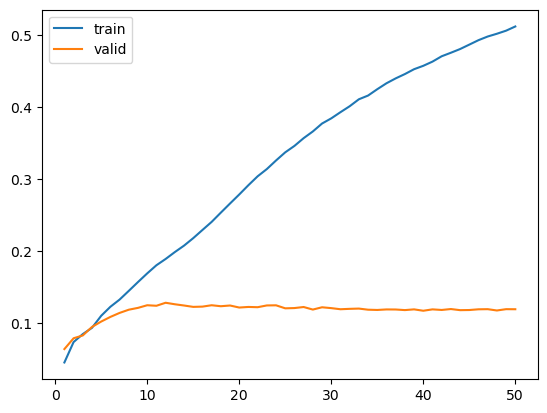

In [48]:
# Bidireccional(32) y 50 épocas
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [34]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [49]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

C:\Users\anben\AppData\Local\Temp\ipykernel_33948\182099320.py:24: UserWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 15ms/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [50]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [51]:
input_text='Introduction to Latent Matrix'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 12ms/step


'Introduction to Latent Matrix csv concept'

### 7 - Beam search y muestreo aleatorio

In [52]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [53]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0] 

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens) 

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update)) 

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens) 

    return history_tokens

In [54]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="Introduction to Latent Matrix")

1/1 [==============================] - 0s 16ms/step


In [55]:
# veamos las salidas
decode(salidas[0])

['to latent matrix csv concept markup the save 2']

### 8 - Conclusiones
El modelo entrenado tuvo un muy mal desempeño en la validación. 
Se probó sin usar LSTM Bidireccional, con 100 épocas, Bidireccional con 64 neuronas (o sea 128). No se obtuvieron mejores resultados.
